Intro) Le but de ce projet est est de réaliser une analyse du marché des restaurants en France via Tripadvisor et de construire des dashboards synthetisant les informations obtenues.

Dans ce notebook, on met réalise des requetes sur une base MongoDB pour produire des indicateurs, graphs sur le marché des restaurants en France.

In [1]:
import pandas as pd
import pymongo
import json
import ast
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
#Connection à Mongo en Localhost
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["General"]
mycol = mydb["Restaurants_France"]

In [6]:
#Exemple sur le departement de Paris 
#Ecrire les noms sans guillements
zone_geographique = input("Entrer le nom de la zone d'étude, par exemple le département de Paris")
type_zone_geographique =input("Entrer le type de la zone d'étude : Ville, Departement,Epci ou Region")

Entrer le nom de la zone d'étude, par exemple le département de ParisÎle-de-France
Entrer le type de la zone d'étude : Ville, Departement,Epci ou RegionRegion


Dans cette première requête, on filtre sur la zone géographique spécifiée et on regroupe par catégorie de prix 

In [7]:
#Fonction pour obtenir le nombre de restaurants et les prix
def query(field_to_group_by) :
    try :
        data = mycol.aggregate([
            {"$match" : {f"{type_zone_geographique}":f"{zone_geographique}"}},
            {"$facet": {
                "By_category":[
                    {"$group": {"_id": f"${field_to_group_by}", 
                        "Nb_restaurants": { "$sum": 1 },
                        "Prix_min_moyen": { "$avg": "$Prix_Bas"},
                        "Prix_max_moyen": { "$avg": "$Prix_Haut"},
                    }},
                    {"$addFields":{
                        "Prix_min_moyen" : {"$round":["$Prix_min_moyen",2]},
                        "Prix_max_moyen" : {"$round":["$Prix_max_moyen",2]},
                    }},
                    { "$sort": { "Nb_restaurants": -1 } }
                ],
                "TOTAL":[
                    {"$group": {"_id": "$null", 
                        "Nb_restaurants": { "$sum": 1 },
                        "Prix_min_moyen": { "$avg": "$Prix_Bas"},
                        "Prix_max_moyen": { "$avg": "$Prix_Haut"},
                    }},
                    {"$addFields":{
                        "Prix_min_moyen" : {"$round":["$Prix_min_moyen",2]},
                        "Prix_max_moyen" : {"$round":["$Prix_max_moyen",2]},
                    }},
                    { "$sort": { "Nb_restaurants": -1 } }
                ],
            }}
        ])
    except Exception as e:
        data = None
        print(e)
    return data

Une fois les données sorties de la BDD, on les met en forme

In [8]:
#Mettre les données Sous Pandas
data = list(query("Categorie_Prix"))
categories = pd.DataFrame.from_dict(data[0]["By_category"])
total = pd.DataFrame.from_dict(data[0]["TOTAL"])
total["_id"] = ["TOTAL"]

#Concatener les categories et le total
full_data = pd.concat([categories,total],axis=0,ignore_index =True)
full_data['Prix_moyen'] = full_data[['Prix_min_moyen', 'Prix_max_moyen']].mean(axis=1).round(2)

#Calculer une colonne de Pourcentage par catégorie de Prix
full_data['Pourcentage'] = (full_data.Nb_restaurants / full_data.Nb_restaurants.sum()*2).round(2)

#Afficher
print(f"{type_zone_geographique} = {zone_geographique}")
full_data


Region = Île-de-France


,_id,Nb_restaurants,Prix_min_moyen,Prix_max_moyen,Prix_moyen,Pourcentage
0,€€-€€€,16280,12.98,30.44,21.71,0.52
1,NaN,8228,12.99,30.91,21.95,0.26
2,€,5786,6.68,15.71,11.20,0.18
3,€€€€,1142,38.89,99.88,69.38,0.04
4,TOTAL,31436,12.76,30.38,21.57,1.00


Dans cette 2ème requête, on filtre sur la zone géographique spécifiée et on regroupe par EPCI

In [9]:
#Mettre les données Sous Pandas
data = list(query("Epci"))
categories = pd.DataFrame.from_dict(data[0]["By_category"])
total = pd.DataFrame.from_dict(data[0]["TOTAL"])
total["_id"] = ["TOTAL"]

#Concatener les categories et le total
full_data = pd.concat([categories,total],axis=0,ignore_index =True)
full_data['Prix_moyen'] = full_data[['Prix_min_moyen', 'Prix_max_moyen']].mean(axis=1).round(2)

#Calculer une colonne de Pourcentage par catégorie de Prix
full_data['Pourcentage'] = (full_data.Nb_restaurants / full_data.Nb_restaurants.sum()*2).round(2)

#Afficher
print(f"{type_zone_geographique} = {zone_geographique}")
full_data


Region = Île-de-France


,_id,Nb_restaurants,Prix_min_moyen,Prix_max_moyen,Prix_moyen,Pourcentage
0,Métropole du Grand Paris,25100,12.98,30.99,21.98,0.80
1,CA Versailles Grand Parc (C.A.V.G.P.),577,13.92,32.18,23.05,0.02
2,CU Grand Paris Seine et Oise,441,11.87,28.18,20.02,0.01
3,CA Saint Germain Boucles de Seine,418,12.61,29.12,20.86,0.01
4,CA Roissy Pays de France,400,11.05,26.59,18.82,0.01
5,CA Grand Paris Sud Seine Essonne Sénart,371,8.84,21.90,15.37,0.01
6,CA Communauté Paris-Saclay,364,10.18,25.05,17.62,0.01
7,CA de Saint-Quentin-en-Yvelines,319,11.88,26.20,19.04,0.01
8,CA de Cergy-Pontoise,254,12.32,26.66,19.49,0.01
9,CA Paris - Vallée de la Marne,252,11.05,26.11,18.58,0.01


Dans cette 3ème requête, on filtre sur la zone géographique spécifiée et on compte pour chaque type culinaire, le nombre de restaurants

In [10]:
def query_cuisines():
    try :
        data = mycol.aggregate([
            {"$match" : {f"{type_zone_geographique}":f"{zone_geographique}"}},
            {"$facet": {
                "Nombre_total_restaurants": [
                    {"$group": {"_id": "null", 
                        "Nb_restaurants": { "$sum": 1 }}}
                ],
                "Nombre_restaurants_par_cuisine": [   
                    {"$unwind" : "$Cuisines" },
                    {"$group": {"_id": "$Cuisines", 
                                        "Nb_restaurants_cuisine": { "$sum": 1 }}
                                    },
                    { "$sort": { "Nb_restaurants_cuisine": -1 } }
                ],
            }}
        ])
    except Exception as e :
        data = None
        print(e)
    return data

#Mettre les données Sous Pandas
data = list(query_cuisines())
cuisines = pd.DataFrame.from_dict(data[0]["Nombre_restaurants_par_cuisine"])
total = data[0]["Nombre_total_restaurants"][0]["Nb_restaurants"]

#Calculer une colonne de Pourcentage 
cuisines['Pourcentage'] = (cuisines.Nb_restaurants_cuisine / total).round(2)

#Afficher
print(f"{type_zone_geographique} = {zone_geographique}")
print(f"Total number restaurants = {total}")
cuisines

Region = Île-de-France
Total number restaurants = 31436


,_id,Nb_restaurants_cuisine,Pourcentage
0,Française,11819,0.38
1,Européenne,5165,0.16
2,Asiatique,3707,0.12
3,Italienne,3436,0.11
4,Végétariens bienvenus,3349,0.11
...,...,...,...
154,Calabraise,1,0.00
155,Hollandaise,1,0.00
156,Nord-Est de la Chine,1,0.00
157,Catalane,1,0.00


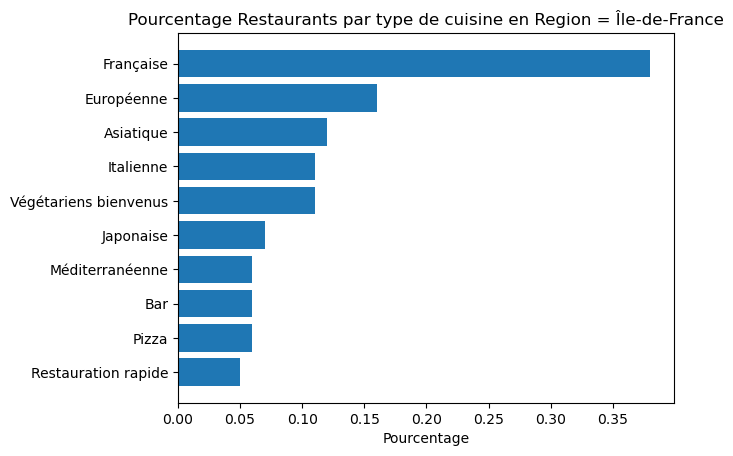

In [11]:
#Bar Chart
plt.rcdefaults()
fig, ax = plt.subplots()

labels = list(cuisines["_id"][:10])
y_pos = np.arange(len(labels))
percentage_graph = list(cuisines["Pourcentage"][:10])

ax.barh(y_pos, percentage_graph, align='center')
ax.set_yticks(y_pos, labels=labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Pourcentage')
ax.set_title(f'Pourcentage Restaurants par type de cuisine en {type_zone_geographique} = {zone_geographique}')

plt.show()

Dans cette 4ème requête, on filtre sur la zone géographique spécifiée et pour chaque intervalle de 30min dans la semaine à partir de lundi minuit à dimanche minuit, on calcule le pourcentage de restaurants ouvertus sur cet intervalle.

In [12]:
format = '%H:%M'
hours = list(pd.date_range("00:30", "23:30", freq="30min").strftime(format))
hours.append("00:00")
results_days = []
results_heures = []
results_nb_ouverts = []
#Requete nombre global de restaurants dans la zone avec horaires renseignes
total_zone = mycol.aggregate([
            {"$match": {
                "$and":  [   
                        {f"{type_zone_geographique}":f"{zone_geographique}"},
                        {"Horaires": {"$exists" : "true", "$not": {"$size": 0}}},
                    ]
                }
            }
        ])
total = len(list(total_zone))
#Requete par heure et par jour
for day in tqdm(["Dim","Lun","Mar","Mer","Jeu","Ven","Sam"]) :
    for string_hour in hours :
        #On part du principe que les restaurants ouvre pour le jour N à min 7h
        if datetime.strptime(string_hour, format) <= datetime.strptime("07:00", format) :
            timestamp_hour = datetime.strptime(string_hour, format)+ timedelta(days=1)
        else :
            timestamp_hour = datetime.strptime(string_hour, format)
        #Requete pour obtenir le nombre de restaurants ouverts ce jour à cette heure
        nb_restaurants_ouverts = mycol.aggregate([
            {"$match": {
                "$and":  [   
                        {f"{type_zone_geographique}":f"{zone_geographique}"},
                        {"Horaires": {"$exists" : "true", "$not": {"$size": 0}}},
                        {f"Horaires.{day}.0.0" : {"$lte": timestamp_hour}},
                        {f"Horaires.{day}.0.1" : {"$gt": timestamp_hour}}
                    ]
                }
            }
        ])
        results_days.append(day)
        results_heures.append(string_hour)
        results_nb_ouverts.append(len(list(nb_restaurants_ouverts)))
dic = {"Jour":results_days,"Heure":results_heures,"Nombre_restaurants_ouverts":results_nb_ouverts}
df = pd.DataFrame.from_dict(dic)
print(f"{type_zone_geographique} = {zone_geographique} ==> {total} restos avec horaires")
df

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:08<00:00, 18.41s/it]

Region = Île-de-France ==> 18618 restos avec horaires


,Jour,Heure,Nombre_restaurants_ouverts
0,Dim,00:30,1301
1,Dim,01:00,1039
2,Dim,01:30,1003
3,Dim,02:00,122
4,Dim,02:30,113
...,...,...,...
331,Sam,22:00,7315
332,Sam,22:30,6381
333,Sam,23:00,4560
334,Sam,23:30,4035


On regroupe et somme par heure pour obtenir les valeur sur l'ensemble de la semaine pour chaque intervalle. Le pourcentage est obtenu en divisant le nombre de restaurants ouverts par le nombre total de restaurants dans la zone * 7 (car on a regroupe sur la semaine)

In [16]:
grouped = df.groupby(["Heure"],as_index=False)[["Nombre_restaurants_ouverts"]].sum()
grouped["Pourcentage_ouverts"] = (grouped.Nombre_restaurants_ouverts / (total*7)).round(2)
grouped

,Heure,Nombre_restaurants_ouverts,Pourcentage_ouverts
0,00:00,13307,0.10
1,00:30,12880,0.10
2,01:00,10295,0.08
3,01:30,9860,0.08
4,02:00,1188,0.01
5,02:30,1121,0.01
6,03:00,893,0.01
7,03:30,890,0.01
8,04:00,653,0.01
9,04:30,646,0.00


On crée un graphique pour visualiser heure par heure le taux d'ouverture des restaurants

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\ibiza\AppData\Local\Temp\ipykernel_58740\1037872487.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


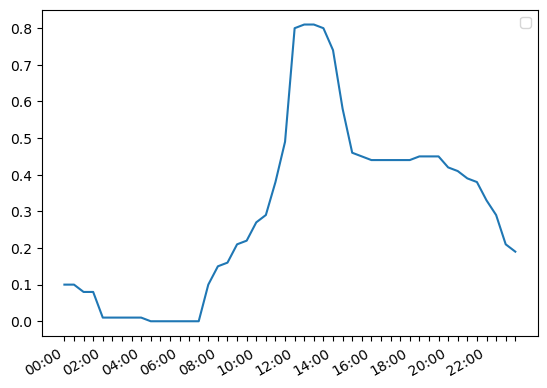

In [20]:
fig, ax = plt.subplots()
ax.plot(grouped["Heure"], grouped["Pourcentage_ouverts"])

fig.autofmt_xdate()
n = 4  # Keeps every 4th label
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
plt.legend()
fig.show()